# Simplifier

In [16]:
import io
from PIL import Image

import matplotlib.cm as cm
import matplotlib.colors as colrs
import matplotlib.pyplot as plt


import pandas as pd
import numpy as np

from shapely.geometry import mapping
from shapely.geometry import Point
from shapely.geometry import shape as Shape
from shapely.ops import transform as Shapely_transform

import folium
import json
import mapply

from simplifier import Simplifier

In [2]:
# Font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['CMU Serif Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 16

mapply.init(
    n_workers=10,
    chunk_size=1,
    progressbar=True
)

def get_map(location=[46.2276, 2.2137], zoom_start=6):
    return folium.Map(location=location, zoom_control=True, zoom_start=zoom_start, 
                    tiles=f'https://api.mapbox.com/styles/v1/landys/cl9ox03vd002t14vqsj0xj8dd/tiles/{{z}}/{{x}}/{{y}}?access_token=pk.eyJ1IjoibGFuZHlzIiwiYSI6ImNraHFjeXA1NzA1ZzkycW11cjl3dnpyMnAifQ.7mSkfJjaSfJXoGBxa_rg1g', attr='Mapbox')


## Load data

In [3]:
france_file = f'data/france.geojson'

fd = open(france_file, 'r')
france_geojson = json.load(fd)
fd.close()

france_mainland = Shape(france_geojson['features'][0]['geometry'])
france_mainland = france_mainland.buffer(0)
# Changing to lat, lon
france_mainland = Shapely_transform(lambda x, y: (y, x), france_mainland)

In [4]:

france_mainland = Shape(france_geojson['features'][0]['geometry'])
france_mainland = france_mainland.buffer(0)
# Changing to lat, lon
france_mainland = Shapely_transform(lambda x, y: (y, x), france_mainland)

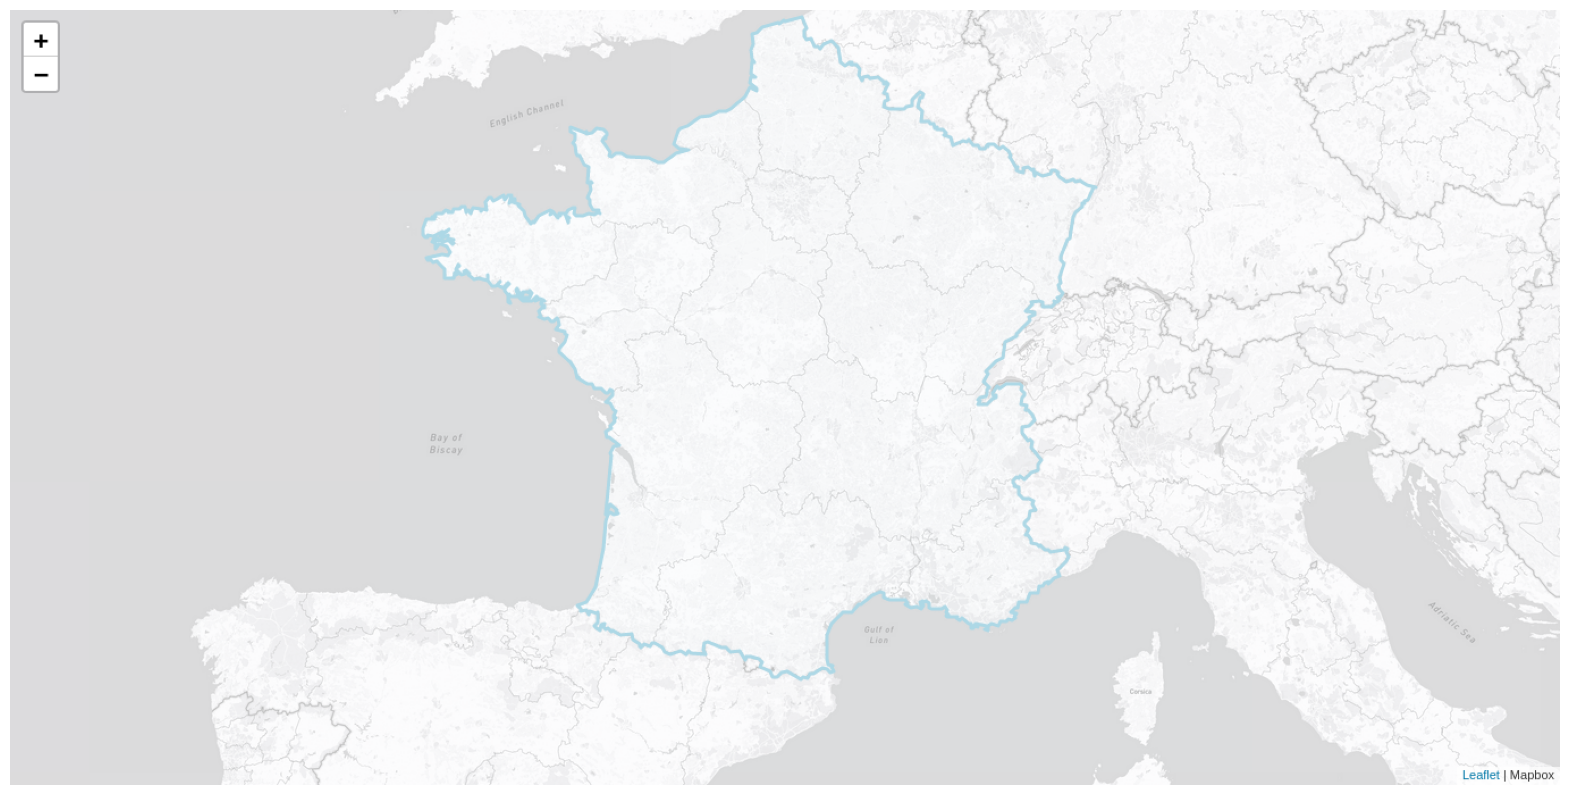

In [17]:
m = get_map()

folium.Polygon(mapping(france_mainland)['coordinates'][0],
    color='lightblue',
    fill_color='lightblue',
    opacity = 1,
    fill_opacity = .01,
    tooltip='France mainland'
    ).add_to(m)

# Show map as HTML (for local use)
# m

# Show map as Image (just for github notebook rendering)
img_data = m._to_png(3)
img = Image.open(io.BytesIO(img_data))

plt.figure(figsize=(20, 15))
plt.imshow(img)
plt.axis('off')
plt.show()

### Load BS deployment data

In [6]:
df_antennas = pd.read_csv('data/2022_T3_sites_Metropole.csv')
df_antennas.head(2)

,code_op,nom_op,num_site,id_site_partage,id_station_anfr,x,y,latitude,longitude,nom_reg,...,site_ZB,site_DCC,site_strategique,site_capa_240mbps,date_ouverturecommerciale_5g,site_5g_700_m_hz,site_5g_800_m_hz,site_5g_1800_m_hz,site_5g_2100_m_hz,site_5g_3500_m_hz
0,20801,Orange,00000001A1,NaN,0802290015,687035.0,6985761.0,49.97028,2.81944,Hauts-de-France,...,0,0,0,0,NaN,0,0,0,0,0
1,20801,Orange,00000001B1,NaN,0642290151,422853.0,6249263.0,43.28861,-0.41389,Nouvelle-Aquitaine,...,0,0,0,1,2020-12-14,0,0,0,1,0


In [7]:
# select one operator
operator = 'Orange'
df_antennas_op = df_antennas[df_antennas['nom_op'] == operator]

# select sites with 4G antennas
df_antennas_op_4G = df_antennas_op[df_antennas_op['site_4g'] == 1].copy()

# make id column
df_antennas_op_4G['antenna_id'] = df_antennas_op_4G.apply(lambda row: f"{row['code_op']}_{row['num_site']}_{row['id_station_anfr']}", axis=1)

# select only the columns we need
# x, y are in Lambert93!
df_antennas_op_4G = df_antennas_op_4G[['antenna_id', 'latitude', 'longitude']]

print(f'The number of 4G antennas for {operator}: {df_antennas_op_4G.shape[0]}')
df_antennas_op_4G.head(2)

The number of 4G antennas for Orange: 28600


,antenna_id,latitude,longitude
0,20801_00000001A1_0802290015,49.97028,2.81944
1,20801_00000001B1_0642290151,43.28861,-0.41389


### Make sites - aggregate by location

In [8]:
df_sites = df_antennas_op_4G.groupby(['latitude', 'longitude'], as_index=False).agg({'antenna_id': lambda x: list(x)})
df_sites.rename(columns={'antenna_id': 'antenna_ids'}, inplace=True)
print(f'The number of 4G sites for {operator}: {df_sites.shape[0]}')

df_sites.head(2)

The number of 4G sites for Orange: 28588


,latitude,longitude,antenna_ids
0,41.36445,9.26527,[20801_00006971V1_02A2290120]
1,41.37444,9.17889,[20801_00010120V1_02A2290147]


### Spatial filter - BSs inside France 

In [9]:
df_sites['inside'] = df_sites.mapply(lambda row: 
                                     france_mainland.contains(Point(row['latitude'], row['longitude'])), 
                                     axis=1)

print(f'Number of sites BS inside France mainland: {df_sites[df_sites["inside"]].shape[0]} 📡🗺️')

df_sites = df_sites[df_sites['inside']].copy()
df_sites.drop(columns=['inside'], inplace=True)

df_sites.reset_index(drop=True, inplace=True)

df_sites = df_sites[['latitude', 'longitude', 'antenna_ids']]
df_sites.head(2)

  0%|          | 0/392 [00:00<?, ?it/s]

Number of sites BS inside France mainland: 28189 📡🗺️


,latitude,longitude,antenna_ids
0,42.35360,2.61295,[20801_00082012K1_0662290324]
1,42.36365,2.65091,[20801_00082061K2_0342290655]


### Plot sites - Small sample

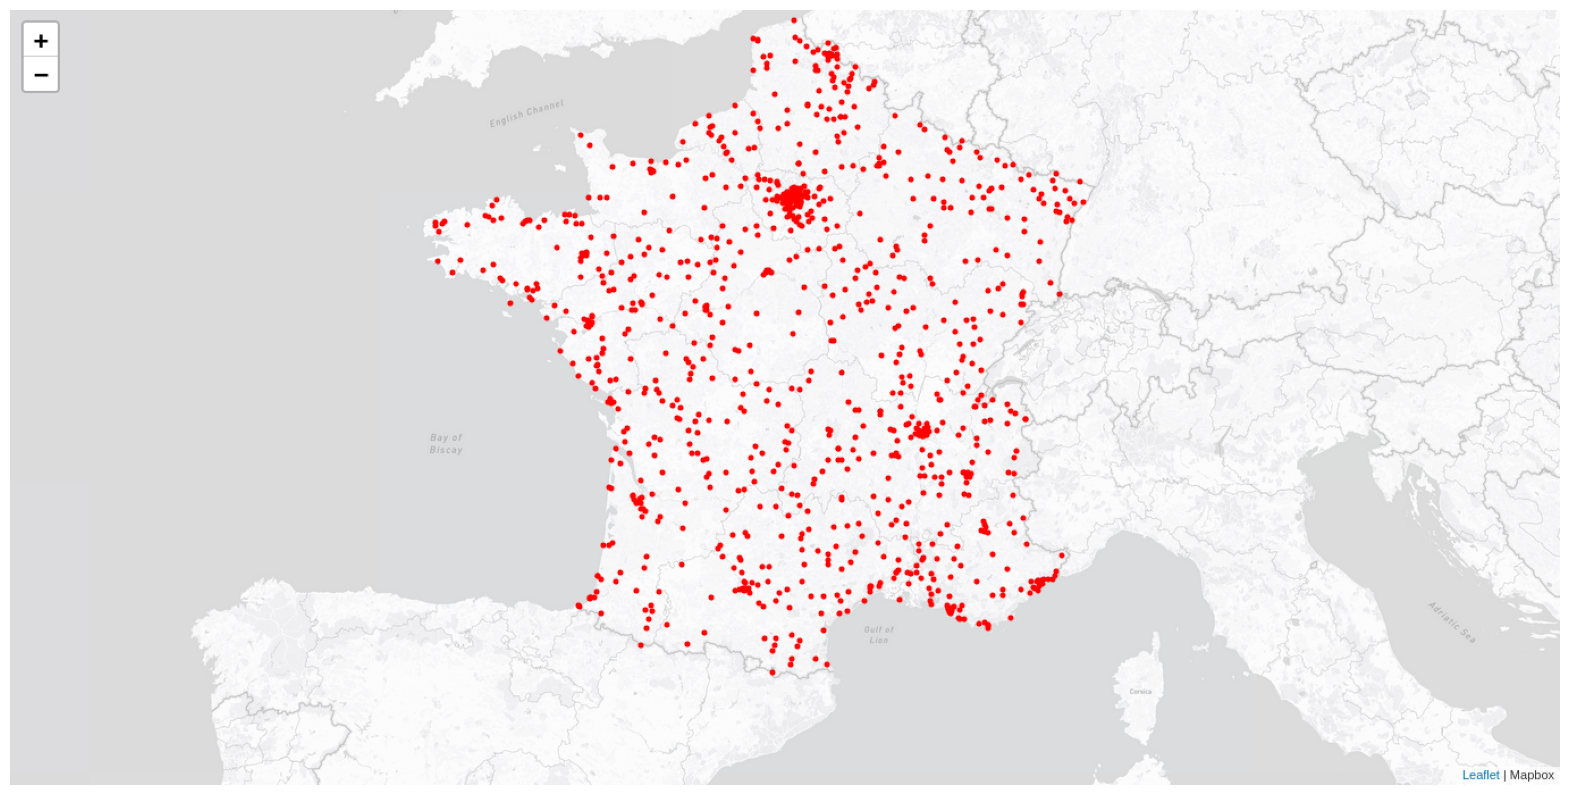

In [18]:
m = get_map()

for site in df_sites.sample(1000, random_state=42).to_dict('records'):
    lat, lon = site['latitude'], site['longitude']
    antennas_ids = site['antenna_ids']
    folium.CircleMarker(
        location=[lat, lon], 
        radius=1, 
        color='red',
        tooltip=f'Antennas: {antennas_ids}'
    ).add_to(m)
    
# Show map as HTML (for local use)
# m

# Show map as Image (just for github notebook rendering)
img_data = m._to_png(3)
img = Image.open(io.BytesIO(img_data))

plt.figure(figsize=(20, 15))
plt.imshow(img)
plt.axis('off')
plt.show()

## Estimate coverage

### Simplifier

In [11]:
sites = zip(df_sites['latitude'], df_sites['longitude'])
sites = np.array(list(sites))

lambert93 = 'epsg:2154' # current version & updated

simplifier = Simplifier(sites, 
                        france_geojson, 
                        'epsg:2154', 
                        model_path='Simplifier_SDUnet_ks2_015',
                        compute_voronoi_tessellation = True)

2023-02-08 20:33:01.927597: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-08 20:33:01.927669: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-08 20:33:01.927692: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (santiago): /proc/driver/nvidia/version does not exist
2023-02-08 20:33:01.927979: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


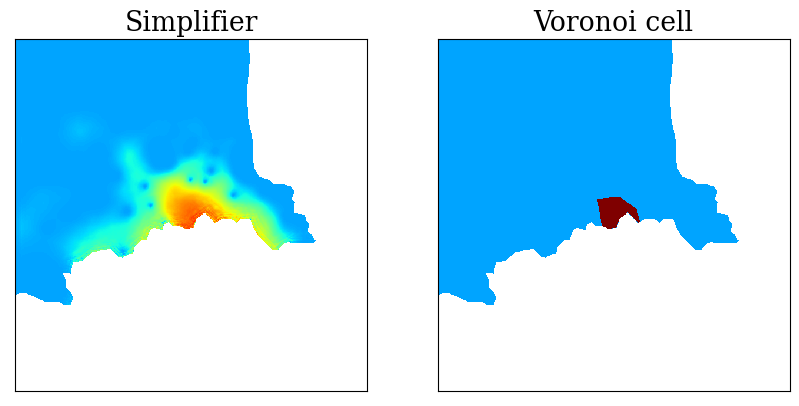

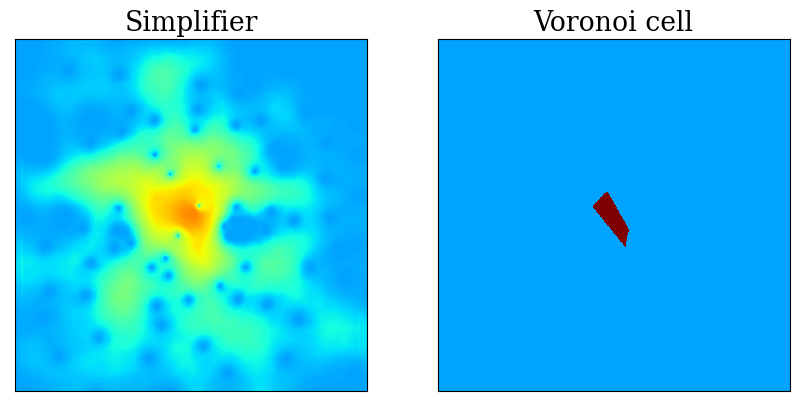

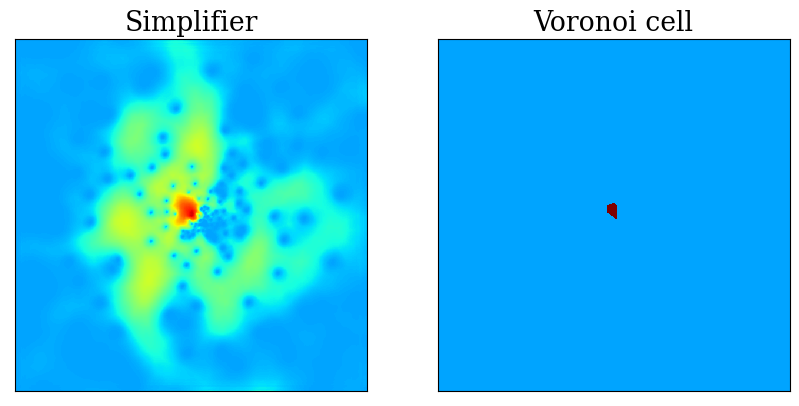

In [12]:
cmap_prob = cm.get_cmap('jet').copy()
cmap_prob.set_under('w', 0)
norm_prob = colrs.LogNorm(vmin=1e-9, vmax=1e-2)

site_indexs = [18, 6783, 10101]
for index, site_index in enumerate(site_indexs):

    prediction, mask = simplifier.get_prediction(site_index)
    voronoi_cell_matrix = simplifier.get_voronoi(site_index)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    ax = axs[0]
    ax.imshow(prediction+mask/1e7, cmap=cmap_prob, norm=norm_prob, origin='lower', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Simplifier')

    ax = axs[1]
    ax.imshow(voronoi_cell_matrix+mask/1e7, cmap=cmap_prob, norm=norm_prob, origin='lower', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Voronoi cell')

    plt.show()